In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

from scipy.stats import skew, kurtosis, jarque_bera, shapiro
from statsmodels.tsa import stattools
import yfinance as yf

import copy

### Simulation
---

In [2]:
def mc_step_strategy(grid, strategy):
    # choose random spin
    x, y = np.random.choice(N, size = 2)
    s = grid[x][y]
    c = strategy[x][y]

    # magnetization
    m = np.sum(grid) / size
    
    # neighbour interactions
    nbs = grid[(x + 1) % N][y] + grid[(x - 1) % N][y] + grid[x][(y + 1) % N] + grid[x][(y - 1) % N]
    h = nbs - alpha * c * m
    
    # probability update +1
    p = 1 / (1 + np.exp(-2 * beta * h))
    if p > np.random.rand():
        grid[x][y] = 1
    else:
        grid[x][y] = -1
        
    # strategy update
    strat = alpha * s * c * m
    if strat < 0:
        strategy[x][y] = c * -1
    
    return grid, strategy, m

In [3]:
# simulation parameters
N = 32
size = int(N**2)

J = 1
alpha = 10
beta = 1.5

nwarumup = int(1e4)
nsim = int(1e6)
interval = 100

In [4]:
# model with strategy spin
np.random.seed(14)
grid = (np.random.randint(0, 2, size = (N, N)) * 2) - 1
strategy = (np.random.randint(0, 2, size = (N, N)) * 2) - 1

grids = np.zeros((int(nsim / interval), N, N))
strats = np.zeros((int(nsim / interval), N, N))
M = np.zeros(nsim)
k = 0

# burn in phase
for _ in range(nwarumup):
    grid, strategy, m = mc_step_strategy(grid, strategy)
    
# actual simulation
for i in range(nsim):
    # monte carlo step
    grid, strategy, m = mc_step_strategy(grid, strategy)
    M[i] = m
    
    # save configurations
    if i % interval == 0:
        grids[k] = grid.copy()
        strats[k] = strategy.copy()
        k += 1

### Data S&P 500
---

In [5]:
ticker = yf.Ticker('^GSPC')
df = ticker.history(period='max')

r_gspc = df['Close'].pct_change().dropna()

### Plots/Tables
---

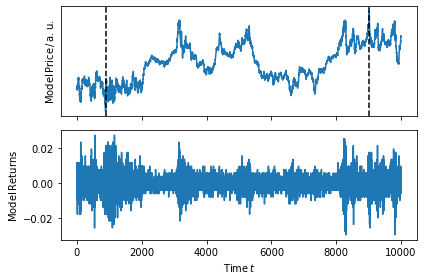

In [6]:
m = M[::interval]
r = np.diff(m)

fig, ax = plt.subplots(2, 1, sharex = True)

ax[0].plot(m)
ax[0].set_ylabel(r'$\mathrm{Model\,Price}\,/\,\mathrm{a.u.}$')
ax[0].set_yticks([])
ax[0].axvline(np.where(m == np.max(m))[0][0], color = 'k', linestyle = '--')
ax[0].axvline(np.where(m == np.min(m))[0][0], color = 'k', linestyle = '--')
ax[1].plot(r)
ax[1].set_ylabel(r'$\mathrm{Model\,Returns}$')
ax[1].set_xlabel(r'$\mathrm{Time}\,t$')

plt.tight_layout()
figname = 'model'
plt.savefig(f'plots/{figname}.pdf')
plt.savefig(f'plots/{figname}.jpeg')

1981-08-31 00:00:00
2021-04-29 00:00:00


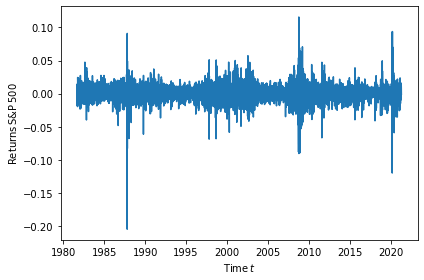

In [8]:
fig, ax = plt.subplots()
start = len(r_gspc) - 10_000 - 1
end = len(r_gspc) - 1
ax.plot(r_gspc.iloc[start:end])
ax.set_ylabel(r'$\mathrm{Returns}\,\mathrm{S&P}\,500$')

ax.set_xlabel(r'$\mathrm{Time}\,t$')
figname = 'gspc'

plt.tight_layout()
plt.savefig(f'plots/{figname}.pdf')
plt.savefig(f'plots/{figname}.jpeg')

print(r_gspc.index[start])
print(r_gspc.index[end])

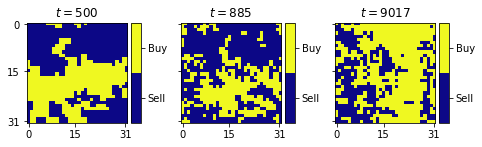

In [9]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (4.53 * 1.5, 2.7))
cmap = plt.get_cmap('plasma', 2)
vmin, vmax = -0.5, 1.5

idx = [
    500,
    np.where(m == m.min())[0][0],
    np.where(m == m.max())[0][0]
]

for i in range(len(idx)):
    im = ax[i].imshow(grids[idx[i]], cmap = cmap, vmin = vmin, vmax = vmax)
    ax[i].set_title(r'$t = %s$' % idx[i])

    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="10%", pad=0.05)

    cbar = fig.colorbar(im, ax=ax[i], cax = cax, ticks = [0, 1])
    cbar.ax.set_yticklabels(['Sell', 'Buy'])
    
    ax[i].set_xticks([0, 15, 31])
    ax[i].set_yticks([0, 15, 31])
    
plt.tight_layout()
figname = 'snapshots'
plt.savefig(f'plots/{figname}.pdf')
plt.savefig(f'plots/{figname}.jpeg')

In [10]:
data = {
    'Model Returns': r,
    'S&P 500 Returns': r_gspc.iloc[start:end].values,
}

In [11]:
res = pd.DataFrame()

for k, v in data.items():
    res.loc[k, 'Skewness'] = np.round(skew(v), 3)
    res.loc[k, 'Kurtosis'] = np.round(kurtosis(v), 3)
    res.loc[k, 'Shapiro-Wilk (p-value)'] = np.round(shapiro(v)[1])
    res.loc[k, 'Jarque-Bera (p-value)'] = np.round(jarque_bera(v)[1])
    
    acor = stattools.acf(v, nlags = 2, fft=True)
    res.loc[k, 'ACF(1)'] = np.round(acor[1], 3)
    res.loc[k, 'ACF(2)'] = np.round(acor[2], 3)
    
res.T.to_csv('tables/statistics.csv')

/home/lars/.local/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Example Lattice
---

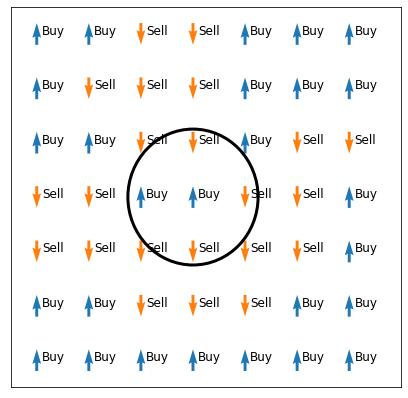

In [12]:
np.random.seed(1)
N = 7

x = np.arange(N) 
y = np.arange(N)

u = np.zeros((N, N), dtype = 'float')
v = ((np.random.randint(2, size = (N, N)) * 2) - 1).astype('float')

fig, ax = plt.subplots(figsize = (N, N))
colors = ['C0', 'C1']
for i, sign in enumerate([1, -1]):
    idx = np.argwhere(v == sign)
    if sign == 1:
        s = 'Buy'
    else:
        s = 'Sell'   
    for (x, y) in idx:
        ax.quiver(x, y - 0.2 * sign, 0, sign, color = colors[i])
        ax.annotate(s, (x + 0.1, y - 0.01), fontsize = 12)
        
# draw nearest neighbours
circle = plt.Circle((int(N/2), int(N/2)), 1.25, color = 'k', fill = False, linewidth = 3)
ax.add_patch(circle)
plt.xlim(-0.5, N)
plt.ylim(-0.5, N - 0.5)
plt.xticks([])
plt.yticks([])

figname = 'schematic'
plt.savefig(f'plots/{figname}.pdf')
plt.savefig(f'plots/{figname}.jpeg')